In [33]:
import struct
import os
import json
import time
import pandas as pd
import numpy as np
from io import StringIO
import seaborn as sns
from PIL import Image

import scipy
import scipy.misc
import scipy.cluster

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import cv2

plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['image.cmap'] = 'gray'

# Silence warnings
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_json('data/corpus.json')

In [3]:
df.columns

Index(['objectID', 'isHighlight', 'accessionNumber', 'isPublicDomain',
       'primaryImage', 'primaryImageSmall', 'additionalImages', 'constituents',
       'department', 'objectName', 'title', 'culture', 'period', 'dynasty',
       'reign', 'portfolio', 'artistRole', 'artistPrefix', 'artistDisplayName',
       'artistDisplayBio', 'artistSuffix', 'artistAlphaSort',
       'artistNationality', 'artistBeginDate', 'artistEndDate', 'objectDate',
       'objectBeginDate', 'objectEndDate', 'medium', 'dimensions',
       'creditLine', 'geographyType', 'city', 'state', 'county', 'country',
       'region', 'subregion', 'locale', 'locus', 'excavation', 'river',
       'classification', 'rightsAndReproduction', 'linkResource',
       'metadataDate', 'repository', 'objectURL', 'tags', 'time', 'tag_count',
       'themes', 'HSV_color'],
      dtype='object')

## Colors

In [9]:
def best_color(codes, counts):
    
    score = counts.astype('float')
    
    for i in range(len(codes)):
        
        # saturated colors score higher
        score[i] += 10*(np.max(codes[i]) - np.mean(codes[i]))
        
        # medium-luminosity colors score higher
        score[i] -= 3*np.abs(127.5 -  np.mean(codes[i]))
    
    index_max = scipy.argmax(score)
        
    return codes[index_max].astype('int')

In [10]:
def get_dominant_color(array):
    
    array = array.reshape(900, 3).astype(float)
    
    codes, dist = scipy.cluster.vq.kmeans(array, 4)
    vecs, dist = scipy.cluster.vq.vq(array, codes)
    counts, bins = scipy.histogram(vecs, len(codes))
    
    B, G, R = best_color(codes, counts)
    
    return R, G, B

In [11]:
def get_grey(array):
    
    array = array.reshape(900, 1).astype(float)
    
    codes, dist = scipy.cluster.vq.kmeans(array, 4)
    vecs, dist = scipy.cluster.vq.vq(array, codes)
    counts, bins = scipy.histogram(vecs, len(codes))
    
    index_max = scipy.argmax(counts)
    V = codes[index_max].astype('int')
    
    return int(V[0]/2.55)

In [12]:
def rgb2hsv(r, g, b):
    
    r, g, b = r/255.0, g/255.0, b/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = df/mx
    v = mx
    
    return int(h), int(s*100), int(v*100)

In [13]:
DATA = 'images'
colors = []
failure = []
ids = []

for folder in os.listdir(DATA):
    if folder[0] != '.':
        for image in os.listdir(DATA + '/' + folder):
            
            try:
                img = Image.open(DATA + '/' + folder + '/' + image)              
            except:
                continue
                
            try:
                img = img.resize((60, 60))
                img = img.crop((15, 15, 45, 45))

                array = np.asarray(img)
                dim = array.shape

                if len(dim) == 3:
                    R, G, B = get_dominant_color(array)
                    H, S, V = rgb2hsv(R, G, B)
                    color = [H, S, V]
                    colors.append(color)

                else:
                    V = get_grey(array)
                    grey = [0, 0, V]
                    colors.append(grey)
                
                ids.append(image[:-4])
                
            except:
                failure.append(image[:-4])
            
                
        time.sleep(3) # cool down

In [14]:
len(ids)

222488

In [15]:
ids = list(map(int, ids))

In [16]:
len(colors)

222488

In [17]:
len(failure)

22

In [18]:
df_colors = pd.DataFrame({'objectID': ids, 'HSV_color': colors})

In [21]:
df_ = pd.merge(df.drop(columns='HSV_color'), df_colors, on='objectID', how='right')
len(df_)

222488

In [28]:
df.head(1)

,objectID,isHighlight,accessionNumber,isPublicDomain,primaryImage,primaryImageSmall,additionalImages,constituents,department,objectName,...,linkResource,metadataDate,repository,objectURL,tags,time,tag_count,themes,HSV_color,color_labels
0,399355,0.0,2012.136.191,1.0,https://images.metmuseum.org/CRDImages/dp/orig...,https://images.metmuseum.org/CRDImages/dp/web-...,[],"[{'role': 'Artist', 'name': 'Étienne Delaune'}]",Drawings and Prints,Print,...,,2019-03-12T19:57:52.973Z,"Metropolitan Museum of Art, New York, NY",https://www.metmuseum.org/art/collection/searc...,"[Buildings, Men, Women, Sheep, Shepherds]",1561.5,5.0,"[Prints, Buildings, Men, Women, Sheep, Shepherds]","[207, 13, 78]",blue


In [23]:
df_.to_json('data/corpus.json')

In [24]:
df = df_

In [106]:
color_labels = []

for ind, item in df['HSV_color'].iteritems():
    
    H, S, V = item[0], item[1], item[2]
    label = ''
    
    if (S <= 10) or ((S <= 20) & (V <= 45)) or (V <= 8):
        
        label = 'grey'
        
    elif (H <= 30) or (H >= 350) :
        
        label = 'red'
    
    elif (H <= 55):
        
        label = 'yellow'
    
    elif (H <= 180):
        
        label = 'green'
        
    elif (H <= 220) & (V >= 50):
        
        label = 'light blue'
    
    elif (H <= 220):
        
        label = 'dark blue'
    
    else:
        label = 'purple'
        
    color_labels.append(label)

In [107]:
df['color_labels'] = color_labels

In [159]:
df.to_json('data/corpus.json')

In [108]:
mountains = df['color_labels'].value_counts()
mountains

light blue    100003
grey           86489
dark blue      13664
purple         13279
green           4370
yellow          2404
red             2279
Name: color_labels, dtype: int64

In [102]:
def show_images(df_):
    
    df_ = df_.reset_index()
    
    
    distrib = np.random.uniform(0, len(df_), 10)
    indexes = df_.index[list(map(int, distrib))]

    df_ = df_.iloc[indexes].reset_index()
    f, axes = plt.subplots(5, 2)
    
    for x in range(5):
        for y in range(2):
            
            objectID = df_['objectID'][(y*5) + x]
            th = int(objectID / 1000) * 1000;
            imgPath = "images/" + str(th) + "/" + str(objectID) + ".jpg";
            
            img = cv2.imread(imgPath, 1)

            axes[x, y].imshow(img, interpolation = 'bicubic')

    return axes
            

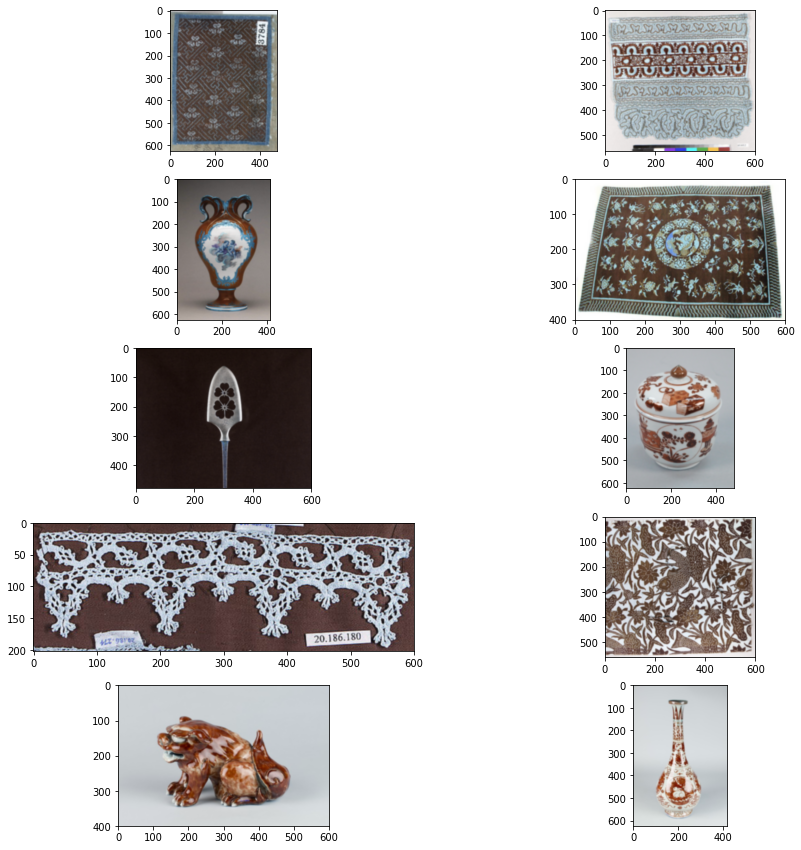

In [200]:
show_images(df[df['color_labels'] == 'red']);

## Time

In [160]:
def get_timespans(df, N):
    
    time = df['time'].dropna().sort_values().values
    separators = []
    linspace = np.linspace(0, 100, N + 1).tolist()[1:-1]
    
    separators.append(np.min(time) - 1)
    
    for percent in linspace:
        separators.append(np.percentile(time, int(percent)))
    
    separators.append(np.max(time) + 1)
    
    return separators

In [161]:
df['time_scale'] = 0

In [162]:
epochs = []

for mountain in mountains.index:
    subset = df[df['color_labels'] == mountain]
    separators = get_timespans(subset, 5)
    
    for i in range(len(separators) - 1):
        df_ = subset[(subset['time'] > separators[i]) & (subset['time'] <= separators[i+1])]
        df_['time_scale'] = i+1
        subset[(subset['time'] > separators[i]) & (subset['time'] <= separators[i+1])] = df_
        
    epochs.append(separators)
    df[df['color_labels'] == mountain] = subset

In [163]:
print(mountains.index)

Index(['light blue', 'grey', 'dark blue', 'purple', 'green', 'yellow', 'red'], dtype='object')


In [164]:
epochs

[[-140001.0, 0.0, 1542.5, 1749.5, 1849.5, 79551.0],
 [-7501.0, 199.5, 1607.0, 1750.0, 1824.5, 2501.5],
 [-320001.0, 650.0, 1510.0, 1700.0, 1832.5, 1950.5],
 [-7501.0, 0.0, 1499.5, 1767.0, 1854.5, 1997.0],
 [-7126.0, -980.0, 449.5, 1349.6, 1792.0, 1989.0],
 [-7501.0, -980.0, 1399.5, 1749.5, 1831.0, 77501.0],
 [-7501.0, 1300.0, 1649.5, 1750.5, 1807.5, 1968.5]]

In [167]:
df[df['color_labels'] == 'grey']['time_scale'].value_counts().sort_index()

1    16616
2    16518
3    17411
4    15757
5    16515
Name: time_scale, dtype: int64

In [166]:
df.to_json('data/corpus.json')

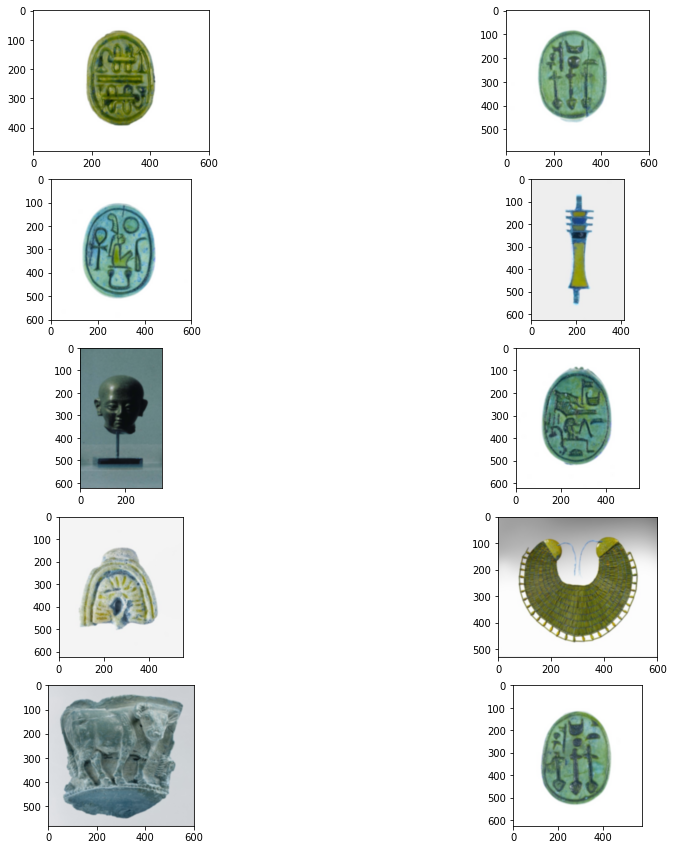

In [193]:
show_images(df[(df['color_labels'] == 'green') & (df['time_scale'] == 1)]);

## Themes

In [195]:
list_themes = []

for ind, item in df['themes'].iteritems():
    for theme in item:
        list_themes.append(theme)

In [204]:
list_themes = pd.Series(list_themes)
list_themes_count = list_themes.value_counts()
list_themes_count[:10]

Prints       31641
Men          30901
Textiles     23143
Vases        22933
Women        22237
Ceramics     21242
Drawings     17171
Flowers      16025
Metalwork    10694
Portraits    10012
dtype: int64

In [224]:
df_themes = pd.DataFrame(list_themes_count)
df_themes[0] = 0

for tag in list_themes_count.index :
    df_themes[tag] = 0
    
df_themes = df_themes.drop(columns = 0)

In [225]:
for ind, item in df['themes'].iteritems():
    if len(item) > 0:
        for tag1 in item :
            for tag2 in item :
                df_themes[tag1][tag2] += 1
                df_themes[tag2][tag1] += 1

In [227]:
df_themes.to_json('data/themes.json')

In [226]:
df_themes.head()

,Prints,Men,Textiles,Vases,Women,Ceramics,Drawings,Flowers,Metalwork,Portraits,...,Clytemnestra,Stained Glass,Marriage,Planets,Hematite,Calypso,Isaac,Ostraca,rein,Coronation of the Virgin
Prints,63282,26264,20,220,16464,0,0,1252,0,4926,...,0,0,2,0,0,0,0,0,0,0
Men,26264,61802,1604,1048,17592,4028,7256,1334,938,9004,...,0,2,2,0,0,0,0,0,0,0
Textiles,20,1604,51818,92,1318,0,4,12818,0,110,...,0,0,0,0,0,0,0,0,0,0
Vases,220,1048,92,46670,970,3268,306,1590,148,16,...,2,0,0,0,0,0,0,0,0,0
Women,16464,17592,1318,970,44474,2538,4650,1526,652,9556,...,0,0,2,0,2,2,0,0,0,0


In [228]:
mountains

light blue    100003
grey           86489
dark blue      13664
purple         13279
green           4370
yellow          2404
red             2279
Name: color_labels, dtype: int64

In [229]:
pca = PCA(n_components = 15)
pca.fit_transform(df_themes)

array([[ 6.29429521e+04, -8.46974217e+03, -1.10486998e+04, ...,
         9.27698014e+02, -1.79386492e+03,  6.36406820e+02],
       [ 6.60008782e+04, -3.79186867e+03,  1.88204953e+03, ...,
        -1.45046288e+03, -1.07430572e+02, -1.11978893e+03],
       [ 6.37407250e+03,  5.37274325e+04, -1.78043203e+04, ...,
        -3.20998023e+02, -2.57185120e+02, -5.12604810e+02],
       ...,
       [-3.29287432e+02, -1.52560878e+02, -7.08891420e+01, ...,
        -3.44666337e+01, -2.18860489e+01,  5.15634703e+00],
       [-3.29290835e+02, -1.52562305e+02, -7.08977214e+01, ...,
        -3.47644220e+01, -2.19489870e+01,  5.26888057e+00],
       [-3.29218586e+02, -1.52570803e+02, -7.09207760e+01, ...,
        -3.46754083e+01, -2.19832759e+01,  5.38703206e+00]])

In [230]:
print(pca.explained_variance_ratio_)

[0.35250432 0.16126036 0.08792643 0.06323288 0.06038328 0.04489536
 0.03339302 0.02373265 0.01871504 0.01437569 0.0125568  0.01071826
 0.0095979  0.00843724 0.00541116]


In [232]:
components_repartition = pd.DataFrame(pca.components_,columns=df_themes.columns)
components_repartition

,Prints,Men,Textiles,Vases,Women,Ceramics,Drawings,Flowers,Metalwork,Portraits,...,Clytemnestra,Stained Glass,Marriage,Planets,Hematite,Calypso,Isaac,Ostraca,rein,Coronation of the Virgin
0,0.592892,0.621475,0.060562,0.027684,0.406862,0.082085,0.101813,0.063849,0.012788,0.159252,...,4.280980e-07,0.000012,3.114368e-05,0.000002,8.000691e-06,8.356869e-06,2.073416e-06,-9.340193e-08,-1.913676e-07,4.419903e-07
1,-0.118493,-0.053459,0.748399,0.063788,-0.023075,0.198904,0.003179,0.420854,0.015648,-0.023180,...,1.688371e-06,-0.000002,-5.787769e-06,0.000006,-9.098682e-07,-9.315949e-07,-1.091473e-07,-1.495868e-07,-2.388836e-07,-4.015784e-07
2,-0.208935,0.034960,-0.336102,0.455856,0.040032,0.704047,0.048242,0.153919,0.022621,0.005473,...,1.712881e-05,0.000001,-5.225695e-06,0.000030,1.085675e-06,1.674991e-06,1.492639e-06,1.923798e-08,-2.038541e-07,-6.736205e-07
3,0.295227,-0.086869,0.088289,0.838421,-0.164685,-0.301085,-0.133871,-0.069758,-0.017150,-0.104718,...,3.731792e-05,-0.000004,1.823027e-06,-0.000015,-6.955464e-06,-8.766084e-06,-5.737172e-06,-1.473923e-07,4.293539e-08,5.878628e-07
4,0.550705,-0.111067,-0.087731,-0.287547,-0.436903,0.288961,-0.305763,0.114154,-0.005748,-0.265300,...,-1.307041e-05,-0.000005,-4.675646e-08,0.000016,-1.920012e-05,-2.295098e-05,-1.351546e-05,-4.107034e-08,6.402765e-08,1.105093e-06
5,-0.205489,0.516792,0.020918,0.012037,-0.491556,-0.067034,0.538291,-0.047224,0.008470,-0.201132,...,6.131645e-07,0.000028,-8.713600e-06,-0.000002,-2.557570e-05,-2.544135e-05,2.895078e-05,2.845916e-07,4.400089e-08,4.619292e-07
6,0.277324,-0.507261,-0.103524,-0.014780,0.197533,-0.045421,0.693645,0.174365,-0.001912,-0.100328,...,-1.003272e-06,-0.000031,-1.058447e-06,-0.000004,1.286889e-05,8.494520e-06,4.409640e-05,-6.801755e-07,-2.998932e-07,1.401673e-06
7,-0.070897,0.112428,-0.311956,-0.005904,-0.072870,-0.345844,-0.127786,0.591410,0.309415,0.051836,...,-4.806675e-07,0.000008,-3.066767e-06,-0.000029,-5.723019e-06,-2.318446e-06,-9.870996e-06,-1.385558e-07,-1.082100e-07,-7.420377e-07
8,0.009476,-0.054334,0.089080,0.002804,0.071276,0.045319,0.009679,-0.201301,0.838472,-0.073603,...,5.016032e-08,-0.000004,2.069536e-06,0.000007,6.256103e-06,3.329788e-06,1.113404e-06,1.481828e-06,-3.851597e-07,5.097624e-07
9,0.146280,-0.035879,-0.036508,0.009801,-0.485923,0.020391,0.114017,0.096646,0.045748,0.505123,...,8.750437e-07,-0.000002,-3.882655e-05,0.000003,-4.585947e-05,-4.468319e-05,1.065717e-05,-2.065187e-06,-9.626637e-08,-7.466352e-07


In [235]:
df['theme_cluster'] = np.nan

In [238]:
for ind, item in df['themes'].iteritems():
    try:
        components = components_repartition[item]
        components['sum'] = 0

        for col in components.columns:
            components['sum'] += components[col]

        slot = components[components['sum'] == np.amax(components['sum'])].index[0]
        df['theme_cluster'][ind] = slot
    except:
        pass

In [248]:
len(df[df['theme_cluster'].isna()])

9448

In [251]:
df = df[~df['theme_cluster'].isna()]
df['theme_cluster'] = df['theme_cluster'].astype('int')

In [252]:
df.to_json('data/corpus_full.json')

In [254]:
df.head(3)

,objectID,isHighlight,accessionNumber,isPublicDomain,primaryImage,primaryImageSmall,additionalImages,constituents,department,objectName,...,repository,objectURL,tags,time,tag_count,themes,HSV_color,color_labels,time_scale,theme_cluster
0,399355,0.0,2012.136.191,1.0,https://images.metmuseum.org/CRDImages/dp/orig...,https://images.metmuseum.org/CRDImages/dp/web-...,[],"[{'role': 'Artist', 'name': 'Étienne Delaune'}]",Drawings and Prints,Print,...,"Metropolitan Museum of Art, New York, NY",https://www.metmuseum.org/art/collection/searc...,"[Buildings, Men, Women, Sheep, Shepherds]",1561.5,5.0,"[Prints, Buildings, Men, Women, Sheep, Shepherds]","[207, 13, 78]",light blue,3,0
1,399640,0.0,2012.136.732,1.0,https://images.metmuseum.org/CRDImages/dp/orig...,https://images.metmuseum.org/CRDImages/dp/web-...,[],"[{'role': 'Artist', 'name': 'Lambrecht Hopfer'}]",Drawings and Prints,Print Ornament & Architecture,...,"Metropolitan Museum of Art, New York, NY",https://www.metmuseum.org/art/collection/searc...,"[Ornament, Faces, Female Nudes, Dragons]",1525.0,4.0,"[Prints, Ornament, Faces, Female Nudes, Dragons]","[204, 26, 57]",light blue,2,0
2,399587,0.0,2012.136.518,1.0,https://images.metmuseum.org/CRDImages/dp/orig...,https://images.metmuseum.org/CRDImages/dp/web-...,[],"[{'role': 'Artist', 'name': 'Félix Bracquemond'}]",Drawings and Prints,Print,...,"Metropolitan Museum of Art, New York, NY",https://www.metmuseum.org/art/collection/searc...,"[Rivers, Landscapes, Trees, Boats]",1868.0,4.0,"[Prints, Rivers, Landscapes, Trees, Boats]","[200, 15, 83]",light blue,5,13


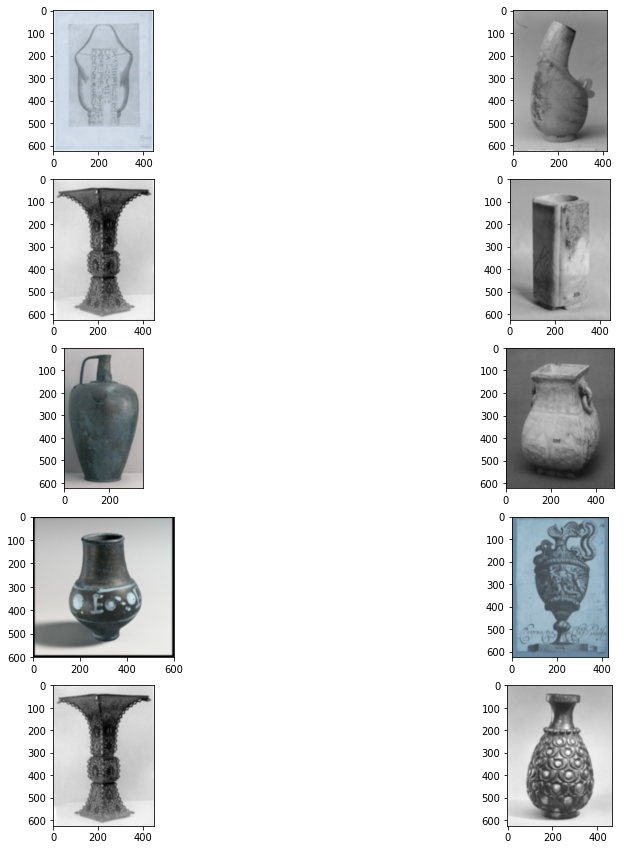

In [283]:
show_images(df[(df['color_labels'] == 'grey') & (
    df['time_scale'] == 2) & (
    df['theme_cluster'] == 3)]);